# Pitching Summary Demo

*By: Thomas Nestico ([@TJStats](https://x.com/TJStats))*

*Data: MLB*

*Note: GitHub Co-Pilot was used for code generation*

### **Introduction**

Baseball is such a fascinating sport, and there is so much data to dig into that it may seem daunting to know where to start. One of my favourite projects I undertook was creating a "Pitching Summary" to help synthesize the data in a more digestible format. Over time, I made meaningful changes to the design of my graphic thanks to the constructive feedback of others. You may have seen some of my graphics out in the wild, such as this season long summary for Tarik Skubal:

![Tarik Skubal TJStats Summary](images/tarik_sukbal_tjstuff.png)

This graphic presents a ton of information. This may feel overwhelming to you, and that is ok. I want to help you understand what is being presented, and this notebook will walk you through each aspect of the graphic, while also providing the code required to generate a similar graphic of your own!

The recreated graphic will be a limited version of the original for simplicity. It will not include the tjStuff+ scores.

This will be the layout of our simplified graphic:

![Pitch Summary Layout](images/pitch_summary.jpg)

### **Process**

This notebook will break down each one of the sections highlighted in the graphic above. To organize the process of generating the graphic, each area of the plot will be separated into their own functions. Each section will have a demo plot to display what the function is plotting.

### **Initialize Notebook**

To jump start this notebook, we will import essential packages which will be used for all the following code.

#### *Versions and Packages*
```
Python 3.9.13
```
```
pandas==1.5.2
numpy==1.23.5
seaborn==0.11.1
pybaseball==2.2.7
matplotlib==3.5.1
PIL.Image==10.3.0
requests==2.31.0
```


#### *Import Packages*

In [ ]:
!pip install seaborn
!pip install pybaseball==2.2.7
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb

#### *Plotting Preferences*

We will also set up fonts and plotting preferences.

In [7]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', 
              palette='deep', 
              font='DejaVu Sans', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib
import matplotlib as mpl

# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

#### *Colour Palette*

We will also initialize the Pitch Colour Palette we will be using for this project. The following palette was curated to be accessible to individuals with varying degrees of colourblindness.

In [ ]:
### PITCH COLOURS ###
pitch_colours = {
    ## Fastballs ##
    'FF': {'colour': '#FF007D', 'name': '4-Seam Fastball'},
    'FA': {'colour': '#FF007D', 'name': 'Fastball'},
    'SI': {'colour': '#98165D', 'name': 'Sinker'},
    'FC': {'colour': '#BE5FA0', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'colour': '#F79E70', 'name': 'Changeup'},
    'FS': {'colour': '#FE6100', 'name': 'Splitter'},
    'SC': {'colour': '#F08223', 'name': 'Screwball'},
    'FO': {'colour': '#FFB000', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'colour': '#67E18D', 'name': 'Slider'},
    'ST': {'colour': '#1BB999', 'name': 'Sweeper'},
    'SV': {'colour': '#376748', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'colour': '#311D8B', 'name': 'Knuckle Curve'},
    'CU': {'colour': '#3025CE', 'name': 'Curveball'},
    'CS': {'colour': '#274BFC', 'name': 'Slow Curve'},
    'EP': {'colour': '#648FFF', 'name': 'Eephus'},

    ## Others ##
    'KN': {'colour': '#867A08', 'name': 'Knuckleball'},
    'PO': {'colour': '#472C30', 'name': 'Pitch Out'},
    'UN': {'colour': '#9C8975', 'name': 'Unknown'},
}

# Create a dictionary mapping pitch types to their colors
dict_colour = dict(zip(pitch_colours.keys(), [pitch_colours[key]['colour'] for key in pitch_colours]))

# Create a dictionary mapping pitch types to their colors
dict_pitch = dict(zip(pitch_colours.keys(), [pitch_colours[key]['name'] for key in pitch_colours]))

import matplotlib.pyplot as plt
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 10))

# Plot a square for each pitch type with its corresponding color
for i, pitch_type in enumerate(pitch_colours):
    ax.add_patch(plt.Rectangle((0, i), 1, 1, color=pitch_colours[pitch_type]['colour']))
    ax.text(-0.02, i + 0.5, f'{pitch_type}: {pitch_colours[pitch_type]["name"]} - {pitch_colours[pitch_type]["colour"]}', va='center', ha='right')

# Set the y-axis limits and remove ticks
ax.set_ylim(0, len(pitch_colours))
ax.set_yticks([])
ax.set_ylabel('')

# Remove the x-axis
ax.set_xticks([])
ax.set_xlabel('')
ax.invert_yaxis()

# Set the title
ax.set_title('Pitch Colors')

# Show the plot
plt.show()

### **Data Gathering**

The data in this project is gathered from MLBAM's Baseball Savant CSV Files via the PyBaseball Package. We will continue to use 'Tarik Skubal' as the example pitcher.

The following code gets us Skubal's MLBAMID as well as all of his pitch data from the 2024 MLB Season.

In [ ]:
#print(pyb.playerid_lookup('Skubal','Tarik'))
pitcher_id = pyb.playerid_lookup('Skubal','Tarik').iloc[0]['key_mlbam']
df_pyb = pyb.statcast_pitcher('2024-03-28', '2024-10-01', pitcher_id)
df_pyb.head()

There is some data processing required.

In [11]:
def df_processing(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    # Define the codes for different types of swings and whiffs
    swing_code = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip',
                'swinging_strike_blocked','missed_bunt','bunt_foul_tip']
    whiff_code = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']

    # Create new columns in the DataFrame to indicate swing, whiff, in-zone, out-zone, and chase
    df['swing'] = (df['description'].isin(swing_code))
    df['whiff'] = (df['description'].isin(whiff_code))
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.swing == 1)

    # Convert the pitch type to a categorical variable
    df['pfx_z'] = df['pfx_z'] * 12
    df['pfx_x'] = df['pfx_x'] * 12
    return df

df = df_processing(df_pyb)

For comparison to league averages, I have created a CSV file which includes league average metrics for each pitch and overall.

In [ ]:
# Load the data from CSV file
!wget -O statcast_2024_grouped.csv https://github.com/tnestico/pitching_summary/raw/main/statcast_2024_grouped.csv
df_statcast_group = pd.read_csv('statcast_2024_grouped.csv')

#### Important Columns

Thanks to MLBAM, the [documentation for the Savant CSV Files](https://baseballsavant.mlb.com/csv-docs) is readily accessible. We will highlight the important variables for our project.


##### *General Information*
* game_date - Date of the Game
* pitcher - MLB Player Id tied to the play event
* description - Description of the resulting pitch
* stand - Side of the plate batter is standing
* p_throws - Hand pitcher throws with

##### *Location Characteristics*
* zone - Zone location of the ball when it crosses the plate from the catcher's perspective
* plate_x - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
* plate_z - Vertical position of the ball when it crosses home plate from the catcher's perspective.


##### *Pitch Characteristics*
* pitch_type - The type of pitch derived from Statcast
* release_speed - Pitch velocities out of hand in mph
* release_pos_x - Horizontal Release Position of the ball measured in feet from the catcher's perspective
* release_pos_z - Vertical Release Position of the ball measured in feet from the catcher's perspective
* pfx_x - Horizontal movement in feet from the catcher's perspective (Horizontal Break)
* pfx_z - Vertical movement in feet from the catcher's perspective (Induced Vertical break)
* release_spin - Spin rate of pitch tracked by Statcast
* release_extension - Release extension of pitch in feet as tracked by Statcast

##### *Results Information*
* estimated_woba_using_speedangle - Estimated wOBA based on launch angle and exit velocity (xwOBA)
* delta_run_exp - The change in Run Expectancy before the Pitch and after the Pitch

We will cover each of these features when they appear throughout the project

## **Plotting Functions**

### Biographical Information

Biographical information provides details regarding the pitcher, such as their name, handedness, age, and team.

We will be using the MLB Stats API to gather this information, including the player's headshot. We will use ESPN for the team logos.

#### *Player Headshot*

Through the MLB website, we can get any player's headshot if we have their ID.

Here is a function which gets the Player Headshot:

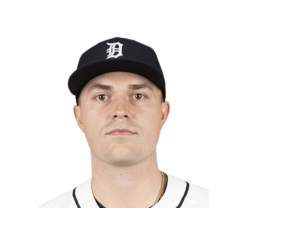

In [30]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(pitcher_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{pitcher_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(pitcher_id=pitcher_id, ax=plt.subplots(figsize=(1, 1))[1])

We now have Tarik Skubal's official MLB headshot!

#### *Player Bio*

We will now work on a function which simply plots text with the player's biographical information. We will be using the MLB Stats API for this step.

In [ ]:
def player_bio(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Extract player information from the JSON data
    player_name = data['people'][0]['fullName']
    pitcher_hand = data['people'][0]['pitchHand']['code']
    age = data['people'][0]['currentAge']
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']

    # Display the player's name, handedness, age, height, and weight on the axis
    ax.text(0.5, 1, f'{player_name}', va='top', ha='center', fontsize=56)
    ax.text(0.5, 0.65, f'{pitcher_hand}HP, Age:{age}, {height}/{weight}', va='top', ha='center', fontsize=30)
    ax.text(0.5, 0.40, f'Season Pitching Summary', va='top', ha='center', fontsize=40)
    ax.text(0.5, 0.15, f'2024 MLB Season', va='top', ha='center', fontsize=30, fontstyle='italic')

    # Turn off the axis
    ax.axis('off')

# Call the player_bio function with the pitcher ID and a new axis of size 10x2
player_bio(pitcher_id, ax=plt.subplots(figsize=(20, 4))[1])

We now have Tarik Skubal's Biographical info! Let's work on getting the team logo.

#### *MLB Logos*

MLBAM does not provide an simple way method to read team logos directly from a URL, so we will be using ESPN to help us out. Here is a dictionary with MLB Team abbreviations and their respective logos from ESPN.

In [15]:
import pandas as pd

# List of MLB teams and their corresponding ESPN logo URLs
mlb_teams = [
    {"team": "AZ", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/ari.png&h=500&w=500"},
    {"team": "ATL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/atl.png&h=500&w=500"},
    {"team": "BAL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bal.png&h=500&w=500"},
    {"team": "BOS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bos.png&h=500&w=500"},
    {"team": "CHC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chc.png&h=500&w=500"},
    {"team": "CWS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chw.png&h=500&w=500"},
    {"team": "CIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cin.png&h=500&w=500"},
    {"team": "CLE", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cle.png&h=500&w=500"},
    {"team": "COL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/col.png&h=500&w=500"},
    {"team": "DET", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/det.png&h=500&w=500"},
    {"team": "HOU", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/hou.png&h=500&w=500"},
    {"team": "KC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/kc.png&h=500&w=500"},
    {"team": "LAA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/laa.png&h=500&w=500"},
    {"team": "LAD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/lad.png&h=500&w=500"},
    {"team": "MIA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mia.png&h=500&w=500"},
    {"team": "MIL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mil.png&h=500&w=500"},
    {"team": "MIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/min.png&h=500&w=500"},
    {"team": "NYM", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nym.png&h=500&w=500"},
    {"team": "NYY", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nyy.png&h=500&w=500"},
    {"team": "OAK", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/oak.png&h=500&w=500"},
    {"team": "PHI", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/phi.png&h=500&w=500"},
    {"team": "PIT", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/pit.png&h=500&w=500"},
    {"team": "SD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sd.png&h=500&w=500"},
    {"team": "SF", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sf.png&h=500&w=500"},
    {"team": "SEA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sea.png&h=500&w=500"},
    {"team": "STL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/stl.png&h=500&w=500"},
    {"team": "TB", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tb.png&h=500&w=500"},
    {"team": "TEX", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tex.png&h=500&w=500"},
    {"team": "TOR", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tor.png&h=500&w=500"},
    {"team": "WSH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/wsh.png&h=500&w=500"}
]

# Create a DataFrame from the list of dictionaries
df_image = pd.DataFrame(mlb_teams)
image_dict = df_image.set_index('team')['logo_url'].to_dict()

The following function utilizes the MLB Stats API and the ESPN Images to plot a player's logo.

In [ ]:
def plot_logo(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Construct the URL to fetch team data
    url_team = 'https://statsapi.mlb.com/' + data['people'][0]['currentTeam']['link']

    # Send a GET request to the team URL and parse the JSON response
    data_team = requests.get(url_team).json()

    # Extract the team abbreviation
    team_abb = data_team['teams'][0]['abbreviation']

    # Get the logo URL from the image dictionary using the team abbreviation
    logo_url = image_dict[team_abb]

    # Send a GET request to the logo URL
    response = requests.get(logo_url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')

# Call the plot_logo function with the pitcher ID and a new axis of size 1x1
plot_logo(pitcher_id, ax=plt.subplots(figsize=(1, 1))[1])

Perfect! Tarik Skubal's team logo was plotted successfully.

### Plots



#### *Pitch Velocity Histogram (KDEs)*

Analyzing a pitcher's velocity on their pitches is important at assessing a pitcher's performance and success. One one to illustrate a distribution of a pitcher's velocity is through the use of histograms. For this plot we will be plotting the distribution using a Kernel Density Estimate, which is essentially a smoothed histogram. This type of plot can be seen on the original pitching summary above.

The following function plots a pitch velocity KDE for each of their pitches.

In [ ]:
import math
import matplotlib.gridspec as gridspec

def velocity_kdes(df: pd.DataFrame,
                  ax: plt.Axes,
                  gs: gridspec,
                  gs_x: list,
                  gs_y: list,
                  fig: plt.Figure,
                  df_statcast_group: pd.DataFrame):

    # Get the count of each pitch type and sort them in descending order
    sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)

    # Get the list of pitch types ordered from most to least frequent
    items_in_order = sorted_value_counts.index.tolist()

    # Turn off the axis and set the title for the main plot
    ax.axis('off')
    ax.set_title('Pitch Velocity Distribution', fontdict={'size': 20})

    # Create a grid for the inner subplots
    inner_grid_1 = gridspec.GridSpecFromSubplotSpec(len(items_in_order), 1, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    ax_top = []

    # Create subplots for each pitch type
    for inner in inner_grid_1:
        ax_top.append(fig.add_subplot(inner))

    ax_number = 0

    # Loop through each pitch type and plot the velocity distribution
    for i in items_in_order:
        # Check if all release speeds for the pitch type are the same
        if np.unique(df[df['pitch_type'] == i]['release_speed']).size == 1:
            # Plot a single line if all values are the same
            ax_top[ax_number].plot([np.unique(df[df['pitch_type'] == i]['release_speed']),
                                    np.unique(df[df['pitch_type'] == i]['release_speed'])], [0, 1], linewidth=4,
                                   color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]], zorder=20)
        else:
            # Plot the KDE for the release speeds
            sns.kdeplot(df[df['pitch_type'] == i]['release_speed'], ax=ax_top[ax_number], fill=True,
                        clip=(df[df['pitch_type'] == i]['release_speed'].min(), df[df['pitch_type'] == i]['release_speed'].max()),
                        color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]])
        
        # Plot the mean release speed for the current data
        df_average = df[df['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                               [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                               color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                               linestyle='--')

        # Plot the mean release speed for the statcast group data
        df_average = df_statcast_group[df_statcast_group['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                               [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                               color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                               linestyle=':')

        # Set the x-axis limits
        ax_top[ax_number].set_xlim(math.floor(df['release_speed'].min() / 5) * 5, math.ceil(df['release_speed'].max() / 5) * 5)
        ax_top[ax_number].set_xlabel('')
        ax_top[ax_number].set_ylabel('')

        # Hide the top, right, and left spines for all but the last subplot
        if ax_number < len(items_in_order) - 1:
            ax_top[ax_number].spines['top'].set_visible(False)
            ax_top[ax_number].spines['right'].set_visible(False)
            ax_top[ax_number].spines['left'].set_visible(False)
            ax_top[ax_number].tick_params(axis='x', colors='none')

        # Set the x-ticks and y-ticks
        ax_top[ax_number].set_xticks(range(math.floor(df['release_speed'].min() / 5) * 5, math.ceil(df['release_speed'].max() / 5) * 5, 5))
        ax_top[ax_number].set_yticks([])
        ax_top[ax_number].grid(axis='x', linestyle='--')

        # Add text label for the pitch type
        ax_top[ax_number].text(-0.01, 0.5, i, transform=ax_top[ax_number].transAxes,
                               fontsize=14, va='center', ha='right')
        ax_number += 1

    # Hide the top, right, and left spines for the last subplot
    ax_top[-1].spines['top'].set_visible(False)
    ax_top[-1].spines['right'].set_visible(False)
    ax_top[-1].spines['left'].set_visible(False)

    # Set the x-ticks and x-label for the last subplot
    ax_top[-1].set_xticks(list(range(math.floor(df['release_speed'].min() / 5) * 5, math.ceil(df['release_speed'].max() / 5) * 5, 5)))
    ax_top[-1].set_xlabel('Velocity (mph)')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
velocity_kdes(df=df,
              ax=ax,
              gs=gridspec.GridSpec(1, 1),
              gs_x=[0, 1],
              gs_y=[0, 1],
              fig=fig,
              df_statcast_group=df_statcast_group)

We can now see Tarik Skubal's pitch velocity distributions for each of his pitches!

#### *Rolling Average Usage Plot*

A pitcher's usage is integral to their performance and changes to the way they utilize their arsenal can make or break their results. We wil be plotting a rolling pitch usage chart, which will show how a pitcher's usage varied across the season. We will use a rolling window of 5 games.

In [ ]:
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick

def rolling_pitch_usage(df: pd.DataFrame, ax: plt.Axes, window: int):
        # Calculate the proportion of each pitch type per game
        df_game_group = pd.DataFrame((df.groupby(['game_pk', 'game_date', 'pitch_type'])['release_speed'].count() /
                                df.groupby(['game_pk', 'game_date'])['release_speed'].count()).reset_index())

        # Create a complete list of games
        all_games = pd.Series(df_game_group['game_pk'].unique())

        # Create a complete list of pitch types
        all_pitch_types = pd.Series(df_game_group['pitch_type'].unique())

        # Create a DataFrame with all combinations of games and pitch types
        all_combinations = pd.MultiIndex.from_product([all_games, all_pitch_types], names=['game_pk', 'pitch_type']).to_frame(index=False)

        # Merge this DataFrame with your original DataFrame to ensure all combinations are included
        df_complete = pd.merge(all_combinations, df_game_group, on=['game_pk', 'pitch_type'], how='left')

        # Fill missing values with 0
        df_complete['release_speed'] = df_complete['release_speed'].fillna(0)

        # Create mappings for game numbers and game dates
        game_list = df.sort_values(by='game_date')['game_pk'].unique()
        range_list = list(range(1, len(game_list) + 1))
        game_to_range = dict(zip(game_list, range_list))
        game_to_date = df.set_index('game_pk')['game_date'].to_dict()

        # Map game dates and game numbers to the complete DataFrame
        df_complete['game_date'] = df_complete['game_pk'].map(game_to_date)
        df_complete = df_complete.sort_values(by='game_date')
        df_complete['game_number'] = df_complete['game_pk'].map(game_to_range)

        # Plot the rolling pitch usage for each pitch type
        sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)
        items_in_order = sorted_value_counts.index.tolist()
        max_roll = []

        for i in items_in_order:
                sns.lineplot(x=range(1, max(df_complete[df_complete['pitch_type'] == i]['game_number']) + 1),
                        y=df_complete[df_complete['pitch_type'] == i]['release_speed'].rolling(window).sum() / window,
                        color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                        ax=ax, linewidth=3)
                max_roll.append(np.max(df_complete[df_complete['pitch_type'] == i]['release_speed'].rolling(window).sum() / window))

        # Adjust x-axis limits to start from the window size
        ax.set_xlim(window, len(game_list))
        ax.set_ylim(0, math.ceil(max(max_roll) * 10) / 10)

        # Set axis labels and title
        ax.set_xlabel('Game', fontdict=font_properties_axes)
        ax.set_ylabel('Pitch Usage', fontdict=font_properties_axes)
        ax.set_title(f"{window} Game Rolling Pitch Usage", fontdict=font_properties_titles)

        # Set x-axis to show integer values only
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        # Set y-axis ticks as percentages
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))


rolling_pitch_usage(df, ax=plt.subplots(figsize=(10, 10))[1], window=5)

We now have the rolling usage plot. From this plot, we can see that Skubal's pitch usage throughout the season has been pretty steady without much deviation between groups of starts

#### *Short Form Pitch Movement Plot*

Short Form pitch movement plots illustrate how a pitch moves. When reading one of these plots, it is important to understand what the axes represent. Horizontal Break (HB) is the movement of the pitch parallel to the ground. In my plots, positive HB represents movement of the pitch in the arm-side direction of the pitcher, while negative HB represented glove-side movement.

The vertical axis is Induced Vertical Break (iVB). Induced vertical break is the measurement of a pitches movement perpendicular to the ground due to spin. This means that the movement (or drop) of the pitch due to gravity is not considered. We like to use iVB because it helps capture the movement of the pitch imparted by the pitcher's spin on the baseball. If a pitch has positive iVB, that means that the spin on the ball (back-spin) is causing the ball to counter the effects of gravity (drop less). The opposite can be said about negative iVB, which means that the spin on the baseball (top-spin) causes it to drop more than gravity alone.

HB is represented by *pfx_x* and iVB is represented by *pfx_z*

I encourage you to check out [Lance Brozdowski's Video Covering Short Form Pitch Movement](https://www.youtube.com/watch?v=vwo3JuwtDAE)

Now let's get to the plotting function!

In [ ]:
from matplotlib.ticker import FuncFormatter
def break_plot(df: pd.DataFrame, ax: plt.Axes):


    # Check if the pitcher throws with the right hand
    if df['p_throws'].values[0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['pfx_x']*-1,
                        y=df['pfx_z'],
                        hue=df['pitch_type'],
                        palette=dict_colour,
                        ec='black',
                        alpha=1,
                        zorder=2)

    # Check if the pitcher throws with the left hand
    if df['p_throws'].values[0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['pfx_x'],
                        y=df['pfx_z'],
                        hue=df['pitch_type'],
                        palette=dict_colour,
                        ec='black',
                        alpha=1,
                        zorder=2)

    # Draw horizontal and vertical lines at y=0 and x=0 respectively
    ax.axhline(y=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.axvline(x=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)

    # Set the labels for the x and y axes
    ax.set_xlabel('Horizontal Break (in)', fontdict=font_properties_axes)
    ax.set_ylabel('Induced Vertical Break (in)', fontdict=font_properties_axes)

    # Set the title of the plot
    ax.set_title("Pitch Breaks", fontdict=font_properties_titles)

    # Remove the legend
    ax.get_legend().remove()

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(range(-20, 21, 10))
    ax.set_xticklabels(range(-20, 21, 10), fontdict=font_properties)
    ax.set_yticks(range(-20, 21, 10))
    ax.set_yticklabels(range(-20, 21, 10), fontdict=font_properties)

    # Set the limits for the x and y axes
    ax.set_xlim((-25, 25))
    ax.set_ylim((-25, 25))

    # Add text annotations based on the pitcher's throwing hand
    if df['p_throws'].values[0] == 'R':
        ax.text(-24.2, -24.2, s='← Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)
        ax.text(24.2, -24.2, s='Arm Side →', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)

    if df['p_throws'].values[0] == 'L':
        ax.invert_xaxis()
        ax.text(24.2, -24.2, s='← Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)
        ax.text(-24.2, -24.2, s='Glove Side →', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=10, zorder=3)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Format the x and y axis tick labels as integers
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))


break_plot(df=df,ax=plt.subplots(figsize=(6, 6))[1])

We now have Tarik Skubal's Pitch movement plot! We will include a legend in the full graphic, but for now we can see that Skubal throws 5 distinct pitch types and how each pitch moves compared to the others.

We have now finished up the 3 Plots that will be featured on the Pitching Summary. Now let's get to the tables.

### Tables

#### *Season Pitching Summary*

While there is a way to gather a pitcher's season long data from the MLB Stats API, we will be using the Fangraphs API. The data from Fangraphs is both easily accessible and formatted in such a way that minimal cleaning is required.

The following function returns the Fangraphs pitching Leaderboards for the 2024 season.

In [ ]:
def fangraphs_pitching_leaderboards(season:int):
    url = f"https://www.fangraphs.com/api/leaders/major-league/data?age=&pos=all&stats=pit&lg=all&season={season}&season1={season}&ind=0&qual=0&type=8&month=0&pageitems=500000"
    data = requests.get(url).json()
    df = pd.DataFrame(data=data['data'])
    return df

df_fangraphs = fangraphs_pitching_leaderboards(season = 2024)
df_fangraphs.head()

There is some formatting changes we will need to apply, such as stat name changes and float formats. The following dictionary includes a handful of Fangraphs statistics and their respective format updates.

In [21]:
### FANGRAPHS STATS DICT ###
fangraphs_stats_dict = {'IP':{'table_header':'$\\bf{IP}$','format':'.1f',} ,
 'TBF':{'table_header':'$\\bf{PA}$','format':'.0f',} ,
 'AVG':{'table_header':'$\\bf{AVG}$','format':'.3f',} ,
 'K/9':{'table_header':'$\\bf{K\/9}$','format':'.2f',} ,
 'BB/9':{'table_header':'$\\bf{BB\/9}$','format':'.2f',} ,
 'K/BB':{'table_header':'$\\bf{K\/BB}$','format':'.2f',} ,
 'HR/9':{'table_header':'$\\bf{HR\/9}$','format':'.2f',} ,
 'K%':{'table_header':'$\\bf{K\%}$','format':'.1%',} ,
 'BB%':{'table_header':'$\\bf{BB\%}$','format':'.1%',} ,
 'K-BB%':{'table_header':'$\\bf{K-BB\%}$','format':'.1%',} ,
 'WHIP':{'table_header':'$\\bf{WHIP}$','format':'.2f',} ,
 'BABIP':{'table_header':'$\\bf{BABIP}$','format':'.3f',} ,
 'LOB%':{'table_header':'$\\bf{LOB\%}$','format':'.1%',} ,
 'xFIP':{'table_header':'$\\bf{xFIP}$','format':'.2f',} ,
 'FIP':{'table_header':'$\\bf{FIP}$','format':'.2f',} ,
 'H':{'table_header':'$\\bf{H}$','format':'.0f',} ,
 '2B':{'table_header':'$\\bf{2B}$','format':'.0f',} ,
 '3B':{'table_header':'$\\bf{3B}$','format':'.0f',} ,
 'R':{'table_header':'$\\bf{R}$','format':'.0f',} ,
 'ER':{'table_header':'$\\bf{ER}$','format':'.0f',} ,
 'HR':{'table_header':'$\\bf{HR}$','format':'.0f',} ,
 'BB':{'table_header':'$\\bf{BB}$','format':'.0f',} ,
 'IBB':{'table_header':'$\\bf{IBB}$','format':'.0f',} ,
 'HBP':{'table_header':'$\\bf{HBP}$','format':'.0f',} ,
 'SO':{'table_header':'$\\bf{SO}$','format':'.0f',} ,
 'OBP':{'table_header':'$\\bf{OBP}$','format':'.0f',} ,
 'SLG':{'table_header':'$\\bf{SLG}$','format':'.0f',} ,
 'ERA':{'table_header':'$\\bf{ERA}$','format':'.2f',} ,
 'wOBA':{'table_header':'$\\bf{wOBA}$','format':'.3f',} ,
 'G':{'table_header':'$\\bf{G}$','format':'.0f',} }

For the Graphic we will be displaying the following metrics:

* IP: Innings Pitched
* TBF: Total Batters Faced (also known as PA)
* WHIP: Walks Plus Hits per Inning Pitched
* ERA: Earned Run Average
* FIP: Fielder Independent Pitching
* K%: Strikeout Rate
* BB%: Walk Rate
* K-BB%: Strikeout Minus Walk Rate


In [ ]:
def fangraphs_pitcher_stats(pitcher_id: int, ax: plt.Axes,stats:list, season:int,fontsize:int=20):
    df_fangraphs = fangraphs_pitching_leaderboards(season = season)

    df_fangraphs_pitcher = df_fangraphs[df_fangraphs['xMLBAMID'] == pitcher_id][stats].reset_index(drop=True)

    df_fangraphs_pitcher.loc[0] = [format(df_fangraphs_pitcher[x][0],fangraphs_stats_dict[x]['format']) if df_fangraphs_pitcher[x][0] != '---' else '---' for x in df_fangraphs_pitcher]
    table_fg = ax.table(cellText=df_fangraphs_pitcher.values, colLabels=stats, cellLoc='center',
                    bbox=[0.00, 0.0, 1, 1])

    table_fg.set_fontsize(fontsize)


    new_column_names = [fangraphs_stats_dict[x]['table_header'] if x in df_fangraphs_pitcher else '---' for x in stats]
    # #new_column_names = ['Pitch Name', 'Pitch%', 'Velocity', 'Spin Rate','Exit Velocity', 'Whiff%', 'CSW%']
    for i, col_name in enumerate(new_column_names):
        table_fg.get_celld()[(0, i)].get_text().set_text(col_name)

    ax.axis('off')

stats = ['IP','TBF','WHIP','ERA', 'FIP', 'K%', 'BB%', 'K-BB%']
fangraphs_pitcher_stats(pitcher_id = pitcher_id,
                        ax = plt.subplots(figsize=(10, 1))[1],
                        stats = stats,
                        season = 2024)

#### *Pitch Metric Summary*


Our final component of the graphic is the summary table which details metrics of each pitch.

The table will have the following columns:
* Pitch Type
* Pitch Count
* Pitch Usage (%)
* Velocity (mph)
* Induced Vertical Break (in)
* Horizontal Break (in)
* Spin Rate (rpm)
* Vertical Release Height (ft)
* Horizontal Release Height (ft)
* Extension (ft)
* Run Value (RV/100)
* Zone%
* Chase%
* Whiff%
* Expected wOBA [xwOBA]

With the Data processing complete, we can groupby and aggregate the pitch metrics. The following code also concatenates the individual pitch metrics with a Total summary row.

In [23]:
def df_grouping(df: pd.DataFrame):
    # Group the DataFrame by pitch type and aggregate various statistics
    df_group = df.groupby(['pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        release_speed = ('release_speed','mean'),  # Average release speed
                        pfx_z = ('pfx_z','mean'),  # Average vertical movement
                        pfx_x = ('pfx_x','mean'),  # Average horizontal movement
                        release_spin_rate = ('release_spin_rate','mean'),  # Average spin rate
                        release_pos_x = ('release_pos_x','mean'),  # Average horizontal release position
                        release_pos_z = ('release_pos_z','mean'),  # Average vertical release position
                        release_extension = ('release_extension','mean'),  # Average release extension
                        delta_run_exp = ('delta_run_exp','sum'),  # Total change in run expectancy
                        swing = ('swing','sum'),  # Total swings
                        whiff = ('whiff','sum'),  # Total whiffs
                        in_zone = ('in_zone','sum'),  # Total in-zone pitches
                        out_zone = ('out_zone','sum'),  # Total out-of-zone pitches
                        chase = ('chase','sum'),  # Total chases
                        xwoba = ('estimated_woba_using_speedangle','mean'),  # Average expected wOBA
                    ).reset_index()

    # Map pitch types to their descriptions
    df_group['pitch_description'] = df_group['pitch_type'].map(dict_pitch)

    # Calculate pitch usage as a percentage of total pitches
    df_group['pitch_usage'] = df_group['pitch'] / df_group['pitch'].sum()

    # Calculate whiff rate as the ratio of whiffs to swings
    df_group['whiff_rate'] = df_group['whiff'] / df_group['swing']

    # Calculate in-zone rate as the ratio of in-zone pitches to total pitches
    df_group['in_zone_rate'] = df_group['in_zone'] / df_group['pitch']

    # Calculate chase rate as the ratio of chases to out-of-zone pitches
    df_group['chase_rate'] = df_group['chase'] / df_group['out_zone']

    # Calculate delta run expectancy per 100 pitches
    df_group['delta_run_exp_per_100'] = -df_group['delta_run_exp'] / df_group['pitch'] * 100

    # Map pitch types to their colours
    df_group['colour'] = df_group['pitch_type'].map(dict_colour)

    # Sort the DataFrame by pitch usage in descending order
    df_group = df_group.sort_values(by='pitch_usage', ascending=False)
    colour_list = df_group['colour'].tolist()

    plot_table_all = pd.DataFrame(data={
                'pitch_type': 'All',
                'pitch_description': 'All',  # Description for the summary row
                'pitch': df['pitch_type'].count(),  # Total count of pitches
                'pitch_usage': 1,  # Usage percentage for all pitches (100%)
                'release_speed': np.nan,  # Placeholder for release speed
                'pfx_z': np.nan,  # Placeholder for vertical movement
                'pfx_x': np.nan,  # Placeholder for horizontal movement
                'release_spin_rate': np.nan,  # Placeholder for spin rate
                'release_pos_x': np.nan,  # Placeholder for horizontal release position
                'release_pos_z': np.nan,  # Placeholder for vertical release position
                'release_extension': df['release_extension'].mean(),  # Placeholder for release extension
                'delta_run_exp_per_100': df['delta_run_exp'].sum() / df['pitch_type'].count() * -100,  # Delta run expectancy per 100 pitches
                'whiff_rate': df['whiff'].sum() / df['swing'].sum(),  # Whiff rate
                'in_zone_rate': df['in_zone'].sum() / df['pitch_type'].count(),  # In-zone rate
                'chase_rate': df['chase'].sum() / df['out_zone'].sum(),  # Chase rate
                'xwoba': df['estimated_woba_using_speedangle'].mean()  # Average expected wOBA
            }, index=[0])

    # Concatenate the group DataFrame with the summary row DataFrame
    df_plot = pd.concat([df_group, plot_table_all], ignore_index=True)


    return df_plot, colour_list

Similar to the Fangraphs Table, we have a dictionary which streamlines the formatting. We will also create a list of the ordered columns we will he using.

In [24]:
pitch_stats_dict = {
    'pitch': {'table_header': '$\\bf{Count}$', 'format': '.0f'},
    'release_speed': {'table_header': '$\\bf{Velocity}$', 'format': '.1f'},
    'pfx_z': {'table_header': '$\\bf{iVB}$', 'format': '.1f'},
    'pfx_x': {'table_header': '$\\bf{HB}$', 'format': '.1f'},
    'release_spin_rate': {'table_header': '$\\bf{Spin}$', 'format': '.0f'},
    'release_pos_x': {'table_header': '$\\bf{hRel}$', 'format': '.1f'},
    'release_pos_z': {'table_header': '$\\bf{vRel}$', 'format': '.1f'},
    'release_extension': {'table_header': '$\\bf{Ext.}$', 'format': '.1f'},
    'xwoba': {'table_header': '$\\bf{xwOBA}$', 'format': '.3f'},
    'pitch_usage': {'table_header': '$\\bf{Pitch\%}$', 'format': '.1%'},
    'whiff_rate': {'table_header': '$\\bf{Whiff\%}$', 'format': '.1%'},
    'in_zone_rate': {'table_header': '$\\bf{Zone\%}$', 'format': '.1%'},
    'chase_rate': {'table_header': '$\\bf{Chase\%}$', 'format': '.1%'},
    'delta_run_exp_per_100': {'table_header': '$\\bf{RV\//100}$', 'format': '.1f'}
    }

table_columns = [ 'pitch_description',
            'pitch',
            'pitch_usage',
            'release_speed',
            'pfx_z',
            'pfx_x',
            'release_spin_rate',
            'release_pos_x',
            'release_pos_z',
            'release_extension',
            'delta_run_exp_per_100',
            'whiff_rate',
            'in_zone_rate',
            'chase_rate',
            'xwoba',
            ]


The following function formats the table for plotting

In [25]:
def plot_pitch_format(df: pd.DataFrame):
    # Create a DataFrame for the summary row with aggregated statistics for all pitches
    df_group = df[table_columns].fillna('—')

    # Apply the formats to the DataFrame
    # Iterate over each column in pitch_stats_dict
    for column, props in pitch_stats_dict.items():
        # Check if the column exists in df_plot
        if column in df_group.columns:
            # Apply the specified format to the column values
            df_group[column] = df_group[column].apply(lambda x: format(x, props['format']) if isinstance(x, (int, float)) else x)
    return df_group

To help with assessing a pitcher's performance, we can colour the cells of the table indicating how much greater or worse a pitch is in a certain metric. The following code generates a list of lists which contains colours for highlighting the table.

In [26]:
import matplotlib
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

# Define color maps
cmap_sum = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#648FFF','#FFFFFF','#FFB000'])
cmap_sum_r = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#FFB000','#FFFFFF','#648FFF'])

# List of statistics to color
colour_stats = ['release_speed', 'release_extension', 'delta_run_exp_per_100', 'whiff_rate', 'in_zone_rate', 'chase_rate', 'xwoba']

### GET COLOURS ###
def get_color(value, normalize, cmap_sum):
    color = cmap_sum(normalize(value))
    return mcolors.to_hex(color)

def get_cell_colouts(df_group: pd.DataFrame,
                     df_statcast_group: pd.DataFrame,
                     colour_stats: list,
                     cmap_sum: matplotlib.colors.LinearSegmentedColormap,
                     cmap_sum_r: matplotlib.colors.LinearSegmentedColormap):
    colour_list_df = []
    for pt in df_group.pitch_type.unique():
        colour_list_df_inner = []
        select_df = df_statcast_group[df_statcast_group['pitch_type'] == pt]
        df_group_select = df_group[df_group['pitch_type'] == pt]

        for tb in table_columns:

            if tb in colour_stats and type(df_group_select[tb].values[0]) == np.float64:
                if np.isnan(df_group_select[tb].values[0]):
                    colour_list_df_inner.append('#ffffff')
                elif tb == 'release_speed':
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.95,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.05)
                    colour_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
                elif tb == 'delta_run_exp_per_100':
                    normalize = mcolors.Normalize(vmin=-1.5, vmax=1.5)
                    colour_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
                elif tb == 'xwoba':
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.7,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.3)
                    colour_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum_r))
                else:
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.7,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.3)
                    colour_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
            else:
                colour_list_df_inner.append('#ffffff')
        colour_list_df.append(colour_list_df_inner)
    return colour_list_df

The following fucntion calls all of the functions and plots the table.

In [ ]:
def pitch_table(df: pd.DataFrame, ax: plt.Axes,fontsize:int=20):
    df_group, colour_list = df_grouping(df)
    colour_list_df = get_cell_colouts(df_group, df_statcast_group, colour_stats, cmap_sum, cmap_sum_r)
    df_plot = plot_pitch_format(df_group)

    # Create a table plot with the DataFrame values and specified column labels
    table_plot = ax.table(cellText=df_plot.values, colLabels=table_columns, cellLoc='center',
                        bbox=[0, -0.1, 1, 1],
                        colWidths=[2.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        cellColours=colour_list_df)

    # Disable automatic font size adjustment and set the font size
    table_plot.auto_set_font_size(False)

    table_plot.set_fontsize(fontsize)

    # Scale the table plot
    table_plot.scale(1, 0.5)

    # Correctly format the new column names using LaTeX formatting
    new_column_names = ['$\\bf{Pitch\\ Name}$'] + [pitch_stats_dict[x]['table_header'] if x in pitch_stats_dict else '---' for x in table_columns[1:]]

    # Update the table headers with the new column names
    for i, col_name in enumerate(new_column_names):
        table_plot.get_celld()[(0, i)].get_text().set_text(col_name)

    # Bold the first column in the table
    for i in range(len(df_plot)):
        table_plot.get_celld()[(i+1, 0)].get_text().set_fontweight('bold')

    # Set the color for the first column, all rows except header and last
    for i in range(1, len(df_plot)):
        # Check if the pitch type is in the specified list
        if table_plot.get_celld()[(i, 0)].get_text().get_text() in ['Split-Finger', 'Slider', 'Changeup']:
            table_plot.get_celld()[(i, 0)].set_text_props(color='#000000', fontweight='bold')
        else:
            table_plot.get_celld()[(i, 0)].set_text_props(color='#FFFFFF')
        # Set the background color of the cell
        table_plot.get_celld()[(i, 0)].set_facecolor(colour_list[i-1])

    # Remove the axis
    ax.axis('off')

pitch_table(df = df, ax = plt.subplots(figsize=(25, 8))[1])

We now have the summary table! The last step is to piece all the functions together to make a plot!

## Generating the Pitching Summary

We will be using Gridspec to layout the graphic. Gridspec will allow us to control the spacing and order of the plots. Our preferred layout was covered earlier in this notebook.

Once the grid is initialized, it is a matter of calling the plotting functions! Here is the code to generate the graphic.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def pitching_dashboard(pitcher_id: str, df: pd.DataFrame, stats: list):
    # Create a 20 by 20 figure
    df = df_processing(df)
    fig = plt.figure(figsize=(20, 20))

    # Create a gridspec layout with 8 columns and 6 rows
    # Include border plots for the header, footer, left, and right
    gs = gridspec.GridSpec(6, 8,
                        height_ratios=[2,20,9,36,36,7],
                        width_ratios=[1,18,18,18,18,18,18,1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1,1:3])
    ax_bio = fig.add_subplot(gs[1,3:5])
    ax_logo = fig.add_subplot(gs[1,5:7])

    ax_season_table = fig.add_subplot(gs[2,1:7])

    ax_plot_1 = fig.add_subplot(gs[3,1:3])
    ax_plot_2 = fig.add_subplot(gs[3,3:5])
    ax_plot_3 = fig.add_subplot(gs[3,5:7])

    ax_table = fig.add_subplot(gs[4,1:7])

    ax_footer = fig.add_subplot(gs[-1,1:7])
    ax_header = fig.add_subplot(gs[0,1:7])
    ax_left = fig.add_subplot(gs[:,0])
    ax_right = fig.add_subplot(gs[:,-1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Call the functions
    fontsize = 16
    fangraphs_pitcher_stats(pitcher_id, ax_season_table, stats, season=2024, fontsize=20)
    pitch_table(df, ax_table, fontsize=fontsize)

    player_headshot(pitcher_id, ax=ax_headshot)
    player_bio(pitcher_id, ax=ax_bio)
    plot_logo(pitcher_id, ax=ax_logo)

    velocity_kdes(df=df, ax=ax_plot_1, gs=gs, gs_x=[3,4], gs_y=[1,3], fig=fig, df_statcast_group=df_statcast_group)
    rolling_pitch_usage(df, ax=ax_plot_2, window=5)
    break_plot(df=df, ax=ax_plot_3)

    # Add footer text
    ax_footer.text(0, 1, 'By: @TJStats', ha='left', va='top', fontsize=24)
    ax_footer.text(0.5, 1, 'Colour Coding Compares to League Average By Pitch', ha='center', va='top', fontsize=16)
    ax_footer.text(1, 1, 'Data: MLB, Fangraphs\nImages: MLB, ESPN', ha='right', va='top', fontsize=24)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

# Define the statistics to display in the dashboard
stats = ['IP','TBF','WHIP','ERA', 'FIP', 'K%', 'BB%', 'K-BB%']
pitcher_id = 669373
df_pyb = pyb.statcast_pitcher('2024-03-28', '2024-10-01', pitcher_id)

# Call the pitching_dashboard function with the pitcher ID and the list of statistics
pitching_dashboard(pitcher_id, df_pyb, stats)


Let's try another pitcher!

This time Bryce Miller

In [ ]:
# Define the statistics to display in the dashboard
stats = ['IP','TBF','WHIP','ERA', 'FIP', 'K%', 'BB%', 'K-BB%']
pitcher_id = 682243
df_pyb = pyb.statcast_pitcher('2024-03-28', '2024-10-01', pitcher_id)

# Call the pitching_dashboard function with the pitcher ID and the list of statistics
pitching_dashboard(pitcher_id, df_pyb, stats)

Special thanks to [Ronnie Ortiz](https://github.com/ronniejortiz), we now have a function which automatically gathers the Pitcher's ID given their name.

In [ ]:
pitcher_name = 'Néstor Cortés'
first_name, last_name = pitcher_name.split()

player_id_df = pyb.playerid_lookup(last_name, first_name)

if not player_id_df.empty:
  player_id = player_id_df.iloc[0]['key_mlbam']
  df_pyb = pyb.statcast_pitcher('2024-03-28', '2024-10-01', player_id)
  
  pitching_dashboard(player_id, df_pyb, stats)
else:
  names = pd.DataFrame(pyb.playerid_lookup(last_name, first_name, fuzzy=True))

  for index, row in names.iterrows():
    print(f"{row['name_first']} {row['name_last']}")

## Conclusion

I hope this notebook was both interesting an informative. I wanted to make my code public because I believe it is the best way get others interested in baseball data analytics and inject new insights into an already supportive and thriving community.

Please make any changes you would like to this code. I intend for this notebook to be a framework and help inspire others in their journey within the baseball analytics sphere.

Please let me know if you have any questions!